In [38]:
import torch 
torch.manual_seed(1)
import sys
sys.path.append('..')

from utils.visual import *
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
from models_nf import MixedModelDensityEstimator,DIFDensityEstimatorLayer,RealNVPDensityEstimatorLayer,DIFSamplerLayer, RealNVPSamplerLayer, MixedModelSampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import torch
from torch import nn
from torch.distributions import MultivariateNormal, Categorical, MixtureSameFamily, Uniform
import math

class VariationalInferenceTarget(nn.Module):
    def __init__(self):
        super().__init__()

    def log_prob(self):
        raise NotImplementedError

class Orbits(VariationalInferenceTarget):
    def __init__(self):
        super().__init__()
        self.p = 1
        number_planets = 7
        covs_target = 0.04*torch.eye(self.p).unsqueeze(0).repeat(number_planets,1,1)
        means_target = 2.5*torch.view_as_real(torch.pow(torch.exp(torch.tensor([2j * math.pi / number_planets])), torch.arange(0, number_planets)))
        weights_target = torch.ones(number_planets)
        weights_target = weights_target

        mvn_target = MultivariateNormal(means_target, covs_target)
        cat = Categorical(torch.exp(weights_target) / torch.sum(torch.exp(weights_target)))
        self.mix_target = MixtureSameFamily(cat, mvn_target)

    def log_prob(self, samples):
        return self.mix_target.log_prob(samples.cpu()).to(samples.device)

class BlobDimension2(VariationalInferenceTarget):
    def __init__(self):
        super().__init__()
        self.p = 2
        mixtures_target = 4 + 2*torch.randint(0,6,[1])
        L = torch.randn(mixtures_target, self.p, self.p)
        covs_target = L @ L.transpose(-1, -2) + torch.eye(self.p)
        covs_target = covs_target/2
        means_target = self.p*torch.randn(mixtures_target, self.p)*2
        means_target = means_target
        weights_target = torch.ones(mixtures_target)
        weights_target = weights_target
        mvn_target = MultivariateNormal(means_target, covs_target)
        cat = Categorical(torch.exp(weights_target) / torch.sum(torch.exp(weights_target)))
        self.mvn = MixtureSameFamily(cat, mvn_target)

    def log_prob(self, samples):
        return self.mvn.log_prob(samples.cpu()).to(samples.device)
    def sample(self, num_samples):
        return self.mvn.sample([num_samples])

In [46]:
mvn = torch.distributions.MultivariateNormal(torch.tensor([[-2., -2.],[2.,2.]])*2, torch.eye(2).unsqueeze(0).repeat(2,1,1))
cat = torch.distributions.Categorical(torch.tensor([.5,.5]))
target = torch.distributions.MixtureSameFamily(cat,mvn)
target_log_prob = lambda samples: target.log_prob(samples)

In [47]:
num_samples = 10000
batch_size = 1000
epochs = 10
structure = [[RealNVPSamplerLayer,[64,64,64]],[RealNVPSamplerLayer,[64,64,64]],[RealNVPSamplerLayer,[64,64,64]]]
flow_modified = MixedModelSampler(target_log_prob,2,structure)
flow_modified.train(num_samples,epochs,batch_size)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s, loss = 0.244014]


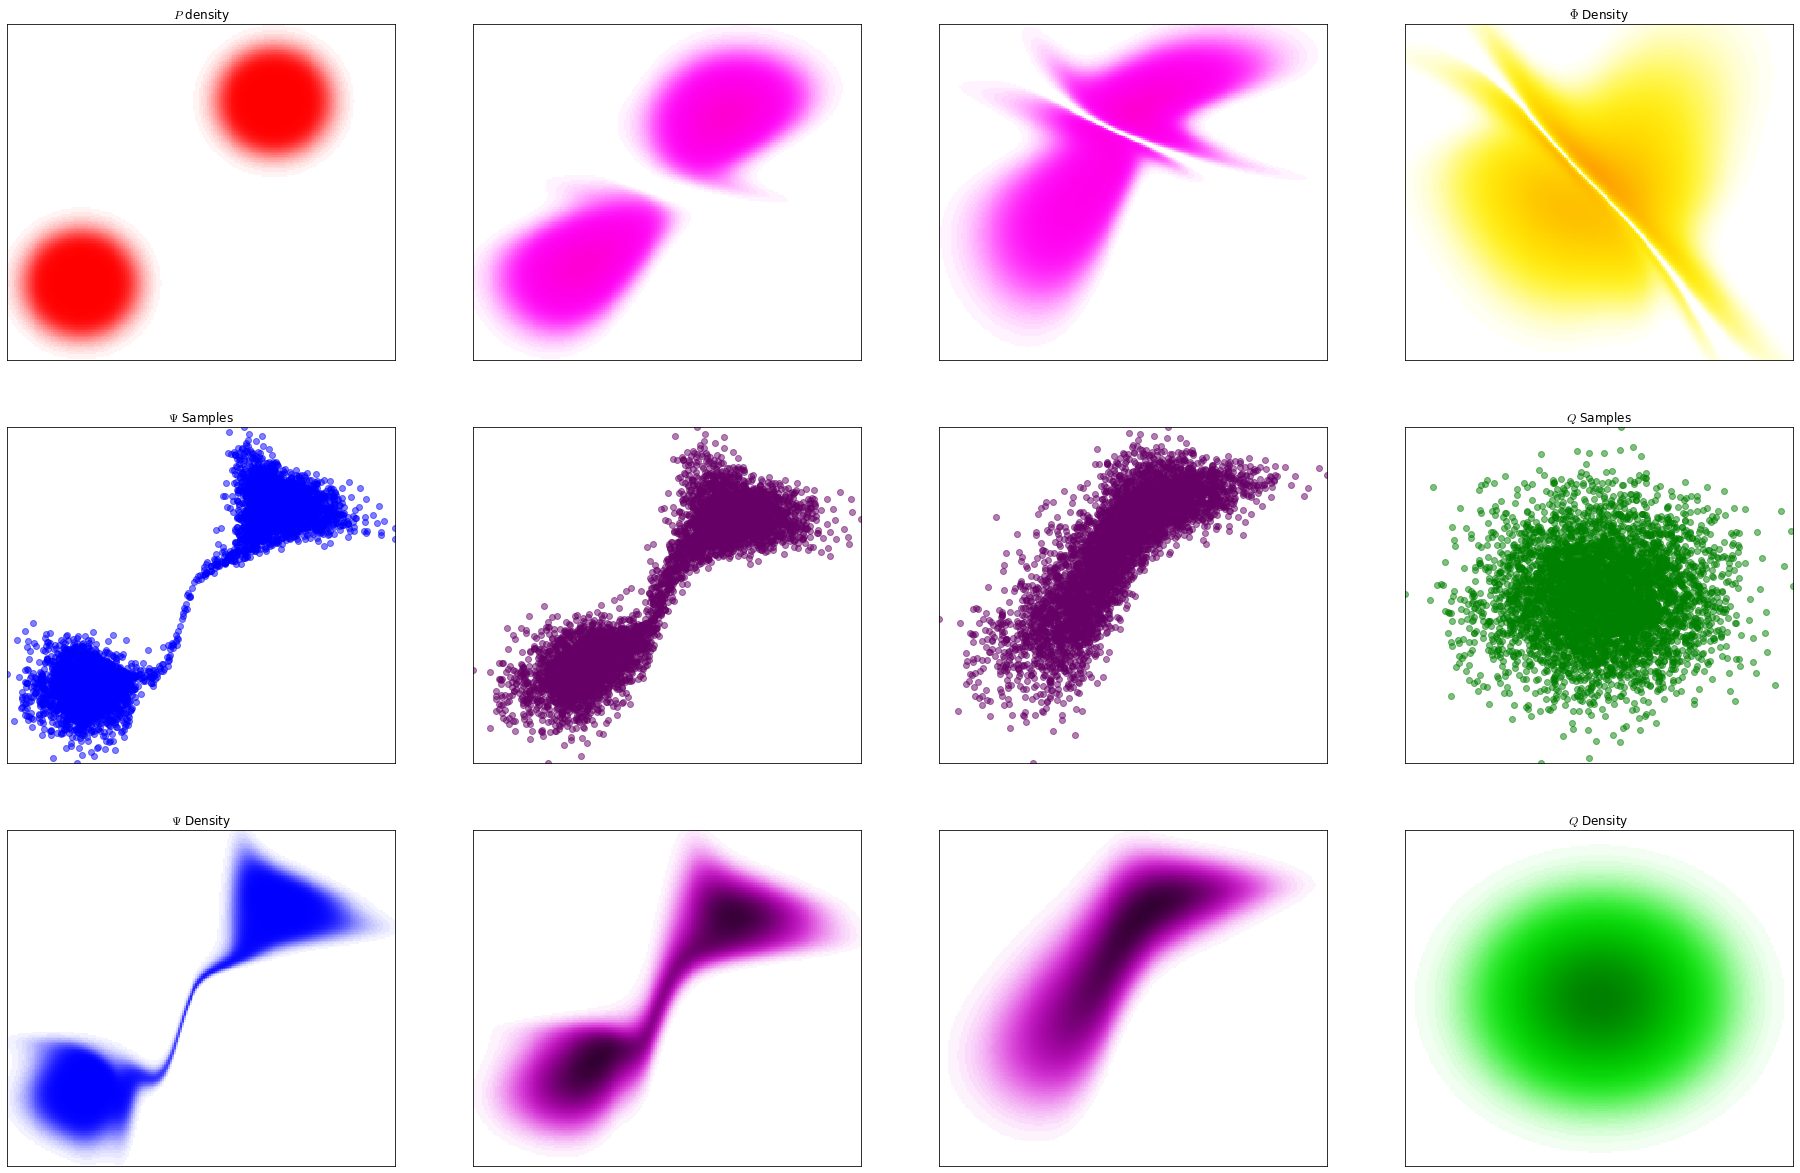

In [48]:
visual_flow(flow_modified)

tensor(-0.2079, grad_fn=<MeanBackward0>)


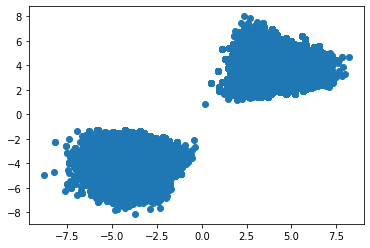

In [49]:
def new_dkl(num_samples):
    x = flow_modified.sample(num_samples)
    log_ratio = - flow_modified.log_density(x) + flow_modified.target_log_density(x)
    log_cat = log_ratio - torch.logsumexp(log_ratio, dim = 0)
    idx = torch.distributions.Categorical(torch.exp(log_cat)).sample([num_samples])
    with torch.no_grad():
        x = x[idx]
    plt.scatter(x[:,0].numpy(), x[:,1].numpy())
    dkl = torch.mean(flow_modified.log_density(x) - flow_modified.target_log_density(x))
    return dkl
new_loss_flow = new_dkl(10000)
print(new_loss_flow)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


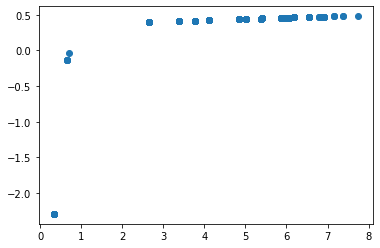

In [54]:
from tqdm import tqdm
optimizer = torch.optim.Adam(flow_modified.para_dict)
epochs = 1
num_samples = 10000
pbar = tqdm(range(epochs))
for i in pbar:
    optimizer.zero_grad()
    new_loss_flow = new_dkl(num_samples)
    new_loss_flow.backward()
    optimizer.step()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
N = 256
orange = np.ones((N, 4))
orange[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
orange[:, 1] = np.geomspace(165 / 256, 1, N)  # G = 165
orange[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 0
orange_cmap = ListedColormap(orange[::-1])

orange_color = "#FFA500"

red = np.ones((N, 4))
red[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
red[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
red[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 0
red_cmap = ListedColormap(red[::-1])

red_color = "#FF0000"

blue = np.ones((N, 4))
blue[:, 0] = np.geomspace(0.001 / 256, 1, N)  # R = 0
blue[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
blue[:, 2] = np.geomspace(255 / 256, 1, N)  # B = 255
blue_cmap = ListedColormap(blue[::-1])

blue_color = "#0000FF"

green = np.ones((N, 4))
green[:, 0] = np.geomspace(0.001 / 256, 1, N)  # R = 0
green[:, 1] = np.geomspace(128 / 256, 1, N)  # G = 128
green[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 128
green_cmap = ListedColormap(green[::-1])

green_color = "#008000"

pink = np.ones((N, 4))
pink[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
pink[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
pink[:, 2] = np.geomspace(211 / 256, 1, N)  # B = 211
pink_cmap = ListedColormap(pink[::-1])

pink_color = "#FF00D3"

purple = np.ones((N, 4))
purple[:, 0] = np.geomspace(51 / 256, 1, N)  # R = 102
purple[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
purple[:, 2] = np.geomspace(51 / 256, 1, N)  # B = 102
purple_cmap = ListedColormap(purple[::-1])

purple_color = "#660066"
###Visualize Sampler Flow dimension >1###
import matplotlib.pyplot as plt
flow_to_visualize = flow_modified
delta = 200
with torch.no_grad():
    backward_samples = [flow_to_visualize.reference.sample(num_samples)]
    grid = torch.cat((torch.cartesian_prod(
        torch.linspace(torch.min(backward_samples[0][:, 0]).item(),
                       torch.max(backward_samples[0][:, 0]).item(), delta),
        torch.linspace(torch.min(backward_samples[0][:, 1]).item(),
                       torch.max(backward_samples[0][:, 1]).item(), delta)),
                      torch.mean(backward_samples[0][:, 2:], dim=0) * torch.ones(delta**2,flow_to_visualize.p - 2)),dim=-1)
    backward_density = [torch.exp(flow_to_visualize.reference.log_density(grid)).reshape(delta, delta).T.cpu().detach()]
    forward_density = [torch.exp(flow_to_visualize.model[-1].log_phi(grid)).reshape(delta, delta).T.cpu().detach()]
    x_range = [[torch.min(backward_samples[0][:, 0]).item(), torch.max(backward_samples[0][:, 0]).item()]]
    y_range = [[torch.min(backward_samples[0][:, 1]).item(), torch.max(backward_samples[0][:, 1]).item()]]
    for i in range(flow_to_visualize.N - 1, -1, -1):
        backward_samples.insert(0, flow_to_visualize.model[i].sample_backward(backward_samples[0]))
        grid = torch.cat((torch.cartesian_prod(
            torch.linspace(torch.min(backward_samples[0][:, 0]).item(),
                           torch.max(backward_samples[0][:, 0]).item(), delta),
            torch.linspace(torch.min(backward_samples[0][:, 1]).item(),
                           torch.max(backward_samples[0][:, 1]).item(), delta)),
                          torch.mean(backward_samples[0][:, 2:], dim=0) * torch.ones(delta**2,flow_to_visualize.p - 2)), dim=-1)
        backward_density.insert(0, torch.exp(flow_to_visualize.model[i].log_psi(grid)).reshape(delta,
                                                                                        delta).T.cpu().detach())
        forward_density.insert(0, torch.exp(flow_to_visualize.model[i].p_log_density(grid)).reshape(delta,
                                                                                       delta).T.cpu().detach())
        x_range.insert(0, [torch.min(backward_samples[0][:, 0]).item(), torch.max(backward_samples[0][:, 0]).item()])
        y_range.insert(0, [torch.min(backward_samples[0][:, 1]).item(), torch.max(backward_samples[0][:, 1]).item()])

fig = plt.figure(figsize=((flow_to_visualize.N + 1) * 8, 3 * 7))
ax = fig.add_subplot(3, flow_to_visualize.N + 1, 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[0][:, 0]).item(),
                             torch.max(backward_samples[0][:, 0]).item(), delta),
              torch.linspace(torch.min(backward_samples[0][:, 1]).item(),
                             torch.max(backward_samples[0][:, 1]).item(), delta), forward_density[0],
              cmap=red_cmap, shading='auto')
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
ax.set_title(r'$P$ density')
for i in range(1, flow_to_visualize.N):
    ax = fig.add_subplot(3, flow_to_visualize.N + 1, i + 1)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
    ax.pcolormesh(torch.linspace(torch.min(backward_samples[i][:, 0]).item(),
                                 torch.max(backward_samples[i][:, 0]).item(), delta),
                  torch.linspace(torch.min(backward_samples[i][:, 1]).item(),
                                 torch.max(backward_samples[i][:, 1]).item(), delta), forward_density[i],
                  cmap=pink_cmap, shading='auto')
ax = fig.add_subplot(3, flow_to_visualize.N + 1, flow_to_visualize.N + 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[-1][:, 0]).item(),
                             torch.max(backward_samples[-1][:, 0]).item(), delta),
              torch.linspace(torch.min(backward_samples[-1][:, 1]).item(),
                             torch.max(backward_samples[-1][:, 1]).item(), delta), forward_density[-1],
              cmap=orange_cmap, shading='auto')
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r'$\Phi$ Density')

ax = fig.add_subplot(3, flow_to_visualize.N + 1, flow_to_visualize.N + 1 + 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.scatter(backward_samples[0][:, 0].cpu(), backward_samples[0][:, 1].cpu(), alpha=0.5, color=blue_color)
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
ax.set_title(r'$\Psi$ Samples')
ax = fig.add_subplot(3, flow_to_visualize.N + 1, 2 * (flow_to_visualize.N + 1) + 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[0][:, 0]).item(),
                             torch.max(backward_samples[0][:, 0]).item(), delta),
              torch.linspace(torch.min(backward_samples[0][:, 1]).item(),
                             torch.max(backward_samples[0][:, 1]).item(), delta), backward_density[0],
              cmap=blue_cmap, shading='auto')
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
ax.set_title(r'$\Psi$ Density')
for i in range(1, flow_to_visualize.N):
    ax = fig.add_subplot(3, flow_to_visualize.N + 1, flow_to_visualize.N + 1 + i + 1)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax.scatter(backward_samples[i][:, 0].cpu(), backward_samples[i][:, 1].cpu(), alpha=0.5,
               color=purple_color)
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
    ax = fig.add_subplot(3, flow_to_visualize.N + 1, 2 * (flow_to_visualize.N + 1) + i + 1)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax.pcolormesh(torch.linspace(torch.min(backward_samples[i][:, 0]).item(),
                                 torch.max(backward_samples[i][:, 0]).item(), delta),
                  torch.linspace(torch.min(backward_samples[i][:, 1]).item(),
                                 torch.max(backward_samples[i][:, 1]).item(), delta), backward_density[i],
                  cmap=purple_cmap, shading='auto')
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
ax = fig.add_subplot(3, flow_to_visualize.N + 1, flow_to_visualize.N + 1 + flow_to_visualize.N + 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.scatter(backward_samples[-1][:, 0].cpu(), backward_samples[-1][:, 1].cpu(), alpha=0.5,
           color=green_color)
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r'$Q$ Samples')
ax = fig.add_subplot(3, flow_to_visualize.N + 1, 2 * (flow_to_visualize.N + 1) + flow_to_visualize.N + 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[-1][:, 0]).item(),
                             torch.max(backward_samples[-1][:, 0]).item(), delta),
              torch.linspace(torch.min(backward_samples[-1][:, 1]).item(),
                             torch.max(backward_samples[-1][:, 1]).item(), delta), backward_density[-1],
              cmap=green_cmap, shading='auto')
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r'$Q$ Density')

In [ ]:
print(flow_modified.loss(torch.randn(num_samples,2)))